In [4]:
#Car2Go
library('data.table')
library('ggplot2')
library('ggthemes')
library('ggmap')
library('dbscan')
library('dplyr')
library('dtplyr')
library('lubridate')#datetime processing
funPath='D:/Git/Rprojects/ECA/function.R'
source(funPath)

In [104]:
dt=fread(input='D:/Git/Rprojects/car2go/Car2go_0413_0428.csv');
distance(-122.3,47.6,-122.3-0.001,47.6-0.001)

[1] 134.2631

In [105]:
o.lub=ymd_hms(as.POSIXct(dt$otime))
d.lub=ymd_hms(as.POSIXct(dt$dtime))
duration=as.numeric(difftime(dt$dtime,dt$otime,units='mins'))

In [106]:
dt=dt[,omd:=mday(o.lub)]
dt=dt[,owd:=wday(o.lub)]
dt=dt[,ohr:=hour(o.lub)]
dt=dt[,omi:=minute(o.lub)]
dt=dt[,dmd:=mday(d.lub)]
dt=dt[,dwd:=wday(d.lub)]
dt=dt[,dhr:=hour(d.lub)]
dt=dt[,dmi:=minute(d.lub)]
dt=dt[,duration:=duration];
dt=dt[,speed:=distance/duration*60]#average speed

In [107]:
dim(dt);nrow(distinct(dt[,list(id)]));head(dt[1:3,])


[1] 53483    23

[1] 744

id,otime,dtime,olon,olat,dlon,dlat,distance,ofuel,dfuel,...,omd,owd,ohr,omi,dmd,dwd,dhr,dmi,duration,speed
AKL4099,2016/4/13 4:26,2016/4/13 4:59,-122.3316,47.59855,-122.3304,47.60615,0.52799,15,15,...,13,4,4,26,13,4,4,59,33,0.9599818
AKL4099,2016/4/13 11:46,2016/4/13 12:20,-122.3304,47.60615,-122.3416,47.61056,0.60550,15,12,...,13,4,11,46,13,4,12,20,34,1.0685294
AKL4099,2016/4/13 13:16,2016/4/13 13:19,-122.3416,47.61056,-122.3473,47.61388,0.34933,12,12,...,13,4,13,16,13,4,13,19,3,6.9866000


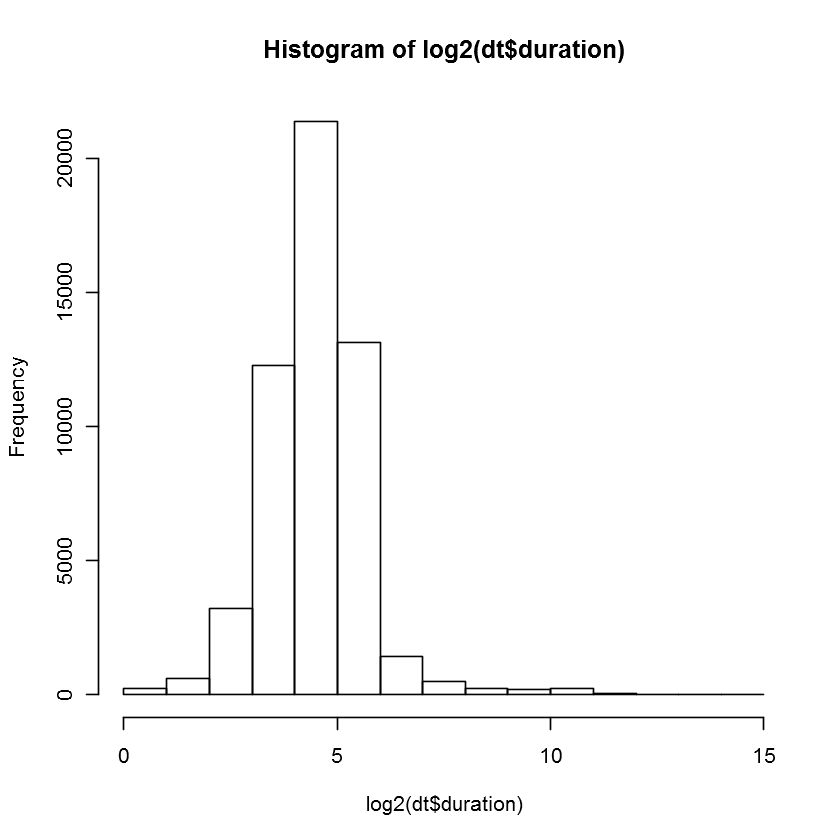

In [108]:
hist(log2(dt$duration))

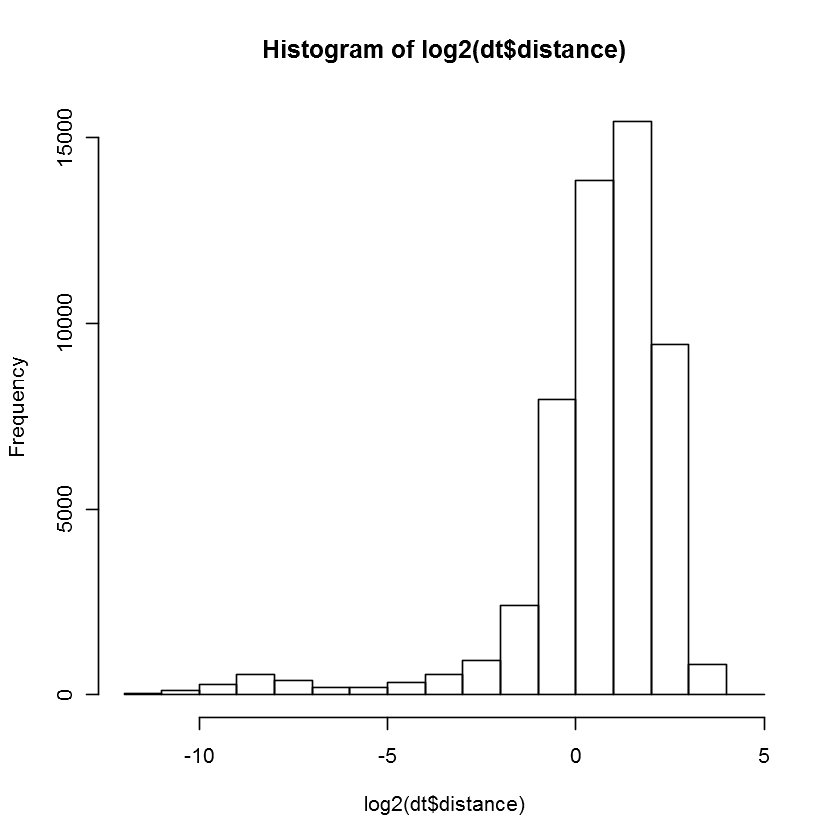

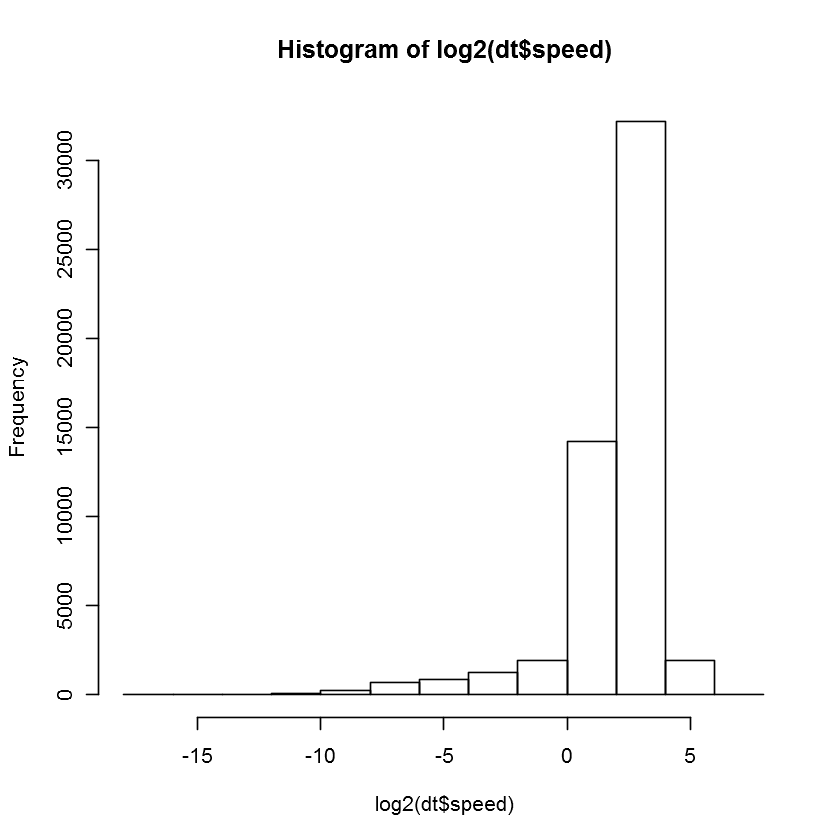

In [109]:
hist(log2(dt$distance))
hist(log2(dt$speed))

In [110]:
#the daily accuppance pattern
dt2=dt[,list(id,omd,owd,ohr,omi,dmd,dwd,dhr,dmi)];
dt2=dt2[,omhr:=24*(omd-1)+ohr]
dt2=dt2[,dmhr:=24*(dmd-1)+dhr]
dt2=dt2[,ommi:=(24*(omd-1)+ohr)*60+omi]
dt2=dt2[,dmmi:=(24*(dmd-1)+dhr)*60+dmi]
head(dt2)

id,omd,owd,ohr,omi,dmd,dwd,dhr,dmi,omhr,dmhr,ommi,dmmi
AKL4099,13,4,4,26,13,4,4,59,292,292,17546,17579
AKL4099,13,4,11,46,13,4,12,20,299,300,17986,18020
AKL4099,13,4,13,16,13,4,13,19,301,301,18076,18079
AKL4099,13,4,13,40,13,4,15,42,301,303,18100,18222
AKL4099,13,4,18,59,13,4,20,36,306,308,18419,18516
AKL4099,14,5,8,25,14,5,9,5,320,321,19225,19265


In [111]:
minhr=min(dt2$omhr)
maxhr=max(dt2$dmhr)
#minhr=min(dt2$ommi)
#maxhr=max(dt2$dmmi)
dt3=data.table(h=0,n=0)[h<0]

In [112]:
for (hr in seq(minhr,maxhr)){
    n=nrow(dt2[hr<=dmhr&hr>=omhr,.N,id])
   # n=nrow(dt2[hr<=dmmi&hr>=ommi,.N,id])
    dt3=rbind(dt3,data.table(h=hr,n=n))
}

In [113]:
dim(dt3);head(dt3);setkey(dt3,h)

[1] 384   2

h,n
288,21
289,19
290,21
291,13
292,20
293,61


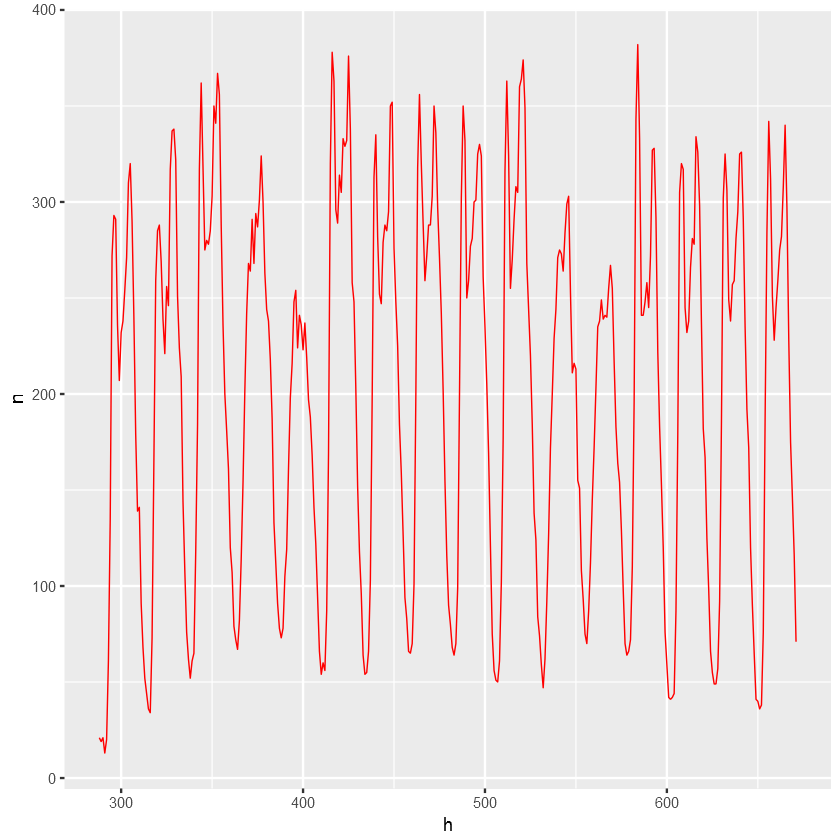

In [114]:
p=ggplot(data=dt3)
p=p+geom_path(aes(x=h,y=n),col='red',size=0.3)
#p=p+geom_point(aes(x=h,y=n),col='red',size=0.5,alpha=0.5)
p

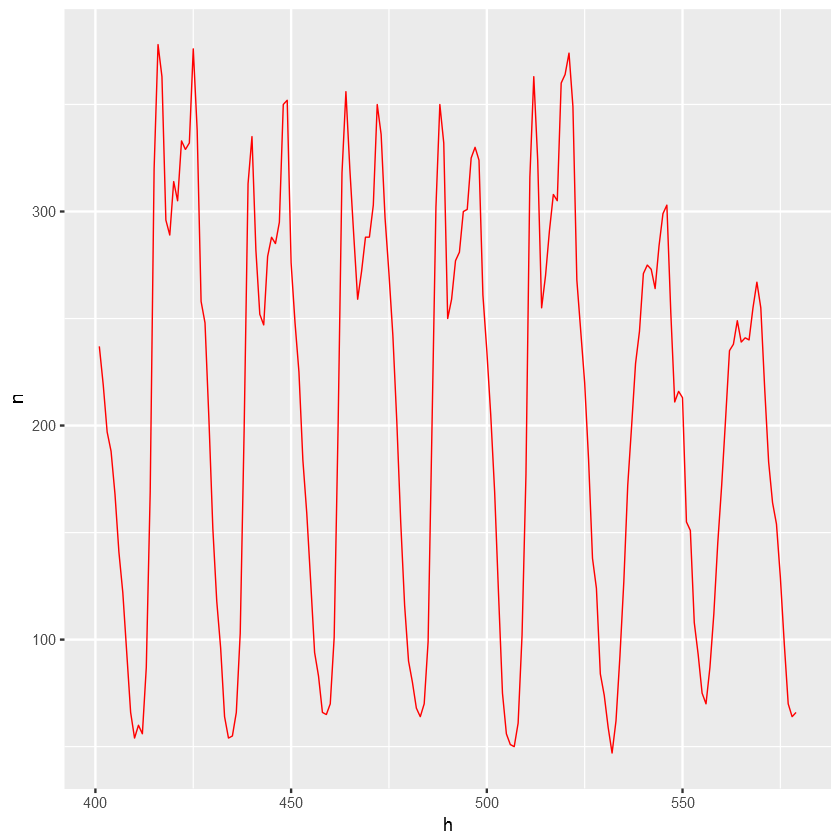

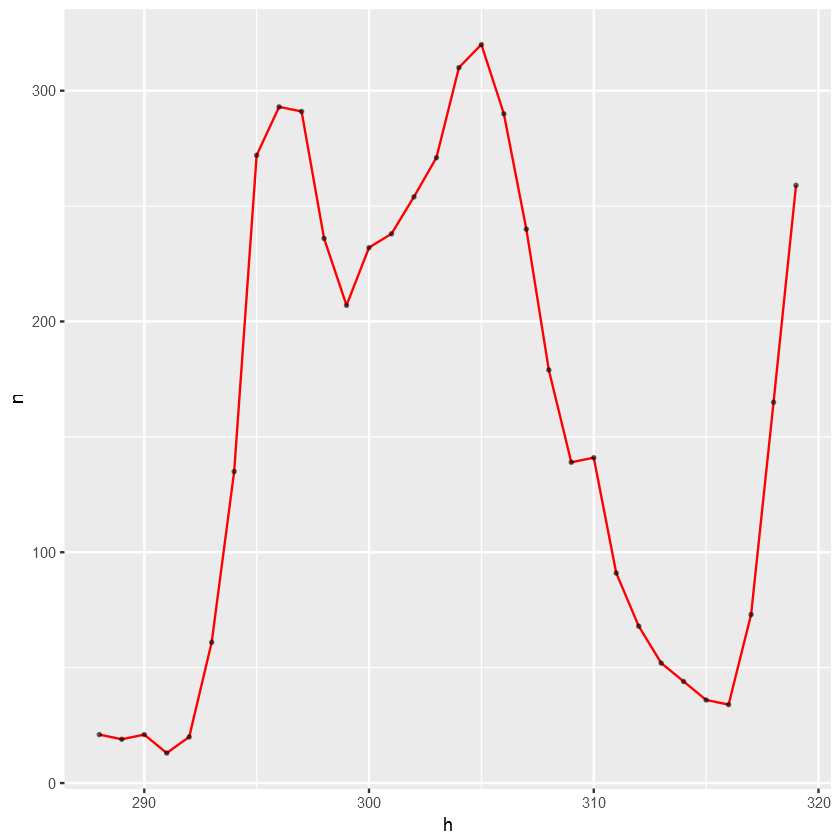

In [115]:
p=ggplot(data=dt3[h>400&h<580,])
p=p+geom_path(aes(x=h,y=n),col='red',size=0.3)
#p=p+geom_point(aes(x=h,y=n),col='red',size=0.5,alpha=0.5)
p
p=ggplot(data=dt3[h<320])
p=p+geom_path(aes(x=h,y=n),col='red')
p=p+geom_point(aes(x=h,y=n),col='black',size=0.5,alpha=0.5)
p

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=47.6,-122.3&zoom=11&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Warning message:
"Removed 1 rows containing missing values (geom_point)."

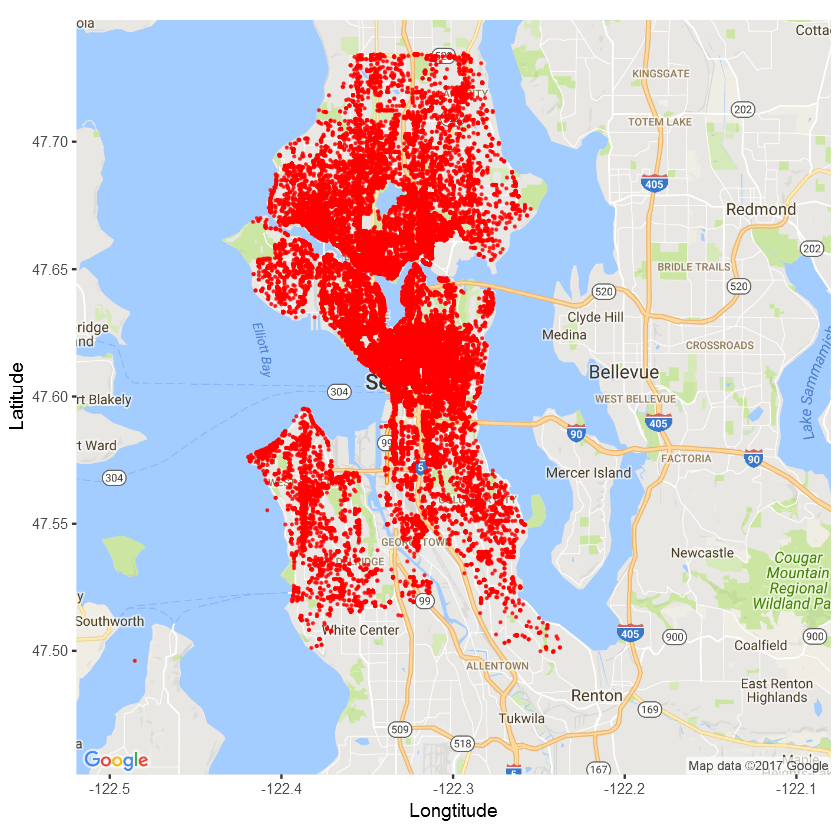

In [116]:
zoomSize=11
dt0=dt[,list(id,omd,owd,ohr,omi,lon=olon,lat=olat)]
temp=dt0
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
centerX=-122.3
centerY=47.6
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'roadmap'))
#p=p+geom_path(data=temp,aes(x=lon,y=lat),color='green',size=0.1)
p=p+geom_point(data=temp,aes(x=lon,y=lat),color='red',size=0.1,alpha=0.75)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.9,0.2))
p

In [117]:
dt1 <- as.matrix(temp[,list(lon,lat)])
cl <- dbscan(dt1, eps = 0.0005, minPts =20)
dt2=data.table(cbind(dt0,c=cl$cluster));
nrow(dt2[c>0,.N,c])

[1] 298

[1] 23846

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=47.61714,-122.33518&zoom=11&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


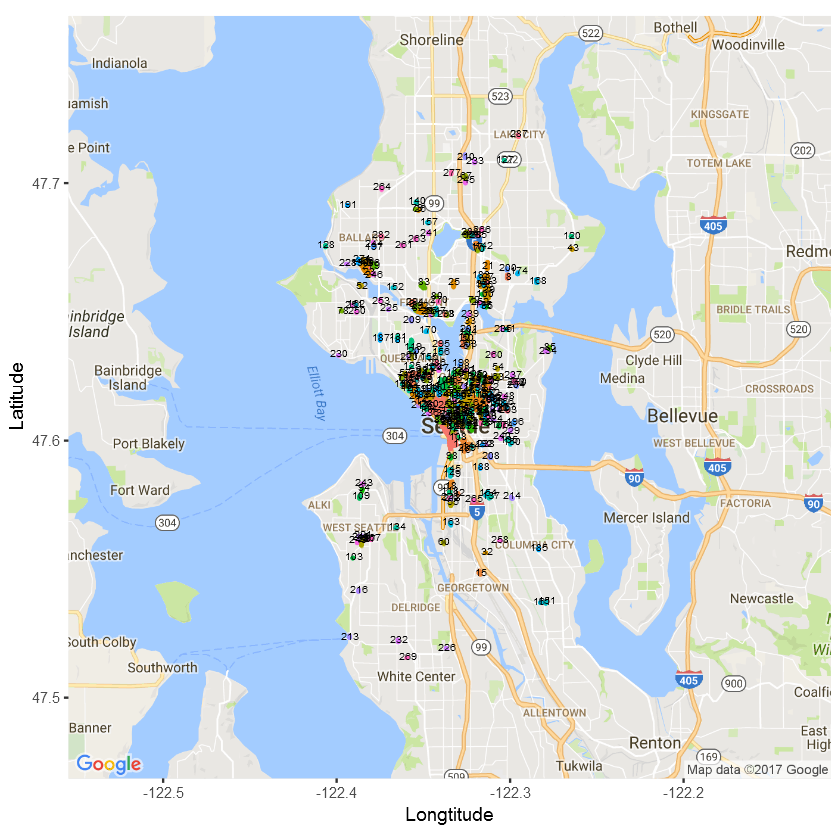

In [118]:
zoomSize=11
temp=dt2[c>0];nrow(temp)
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'roadmap'))
p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(c)),size=0.1,alpha=0.5)
p=p+geom_text(data=temp[,.SD[1],c],nudge_x = 0.0005,nudge_y = 0.0005,aes(x=lon,y=lat,label=c),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position="none")
p

[1] 23846

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=47.61714,-122.33518&zoom=13&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Warning message:
"Removed 5076 rows containing missing values (geom_point)."Warning message:
"Removed 97 rows containing missing values (geom_text)."

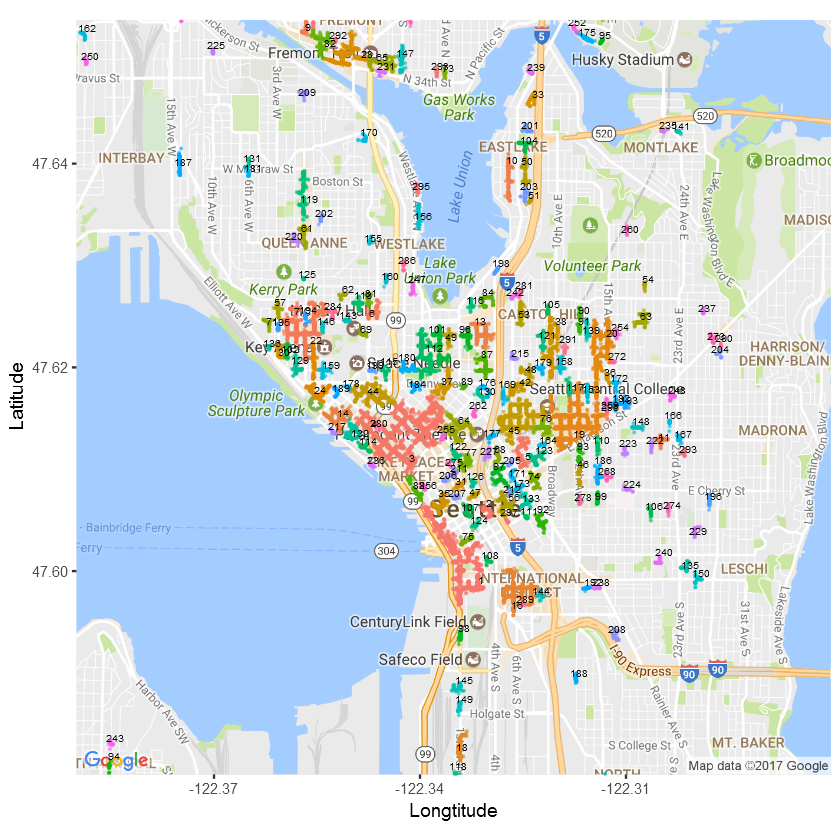

In [126]:
zoomSize=13
temp=dt2[c>0][(lat>47.57)&&(lat<47.63),];nrow(temp)
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'roadmap'))
p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(c)),size=0.1,alpha=0.5)
p=p+geom_text(data=temp[,.SD[1],c],nudge_x = 0.0005,nudge_y = 0.0005,aes(x=lon,y=lat,label=c),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position="none")
p

[1] 23846

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=47.665,-122.315&zoom=14&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Warning message:
"Removed 21568 rows containing missing values (geom_point)."Warning message:
"Removed 269 rows containing missing values (geom_text)."

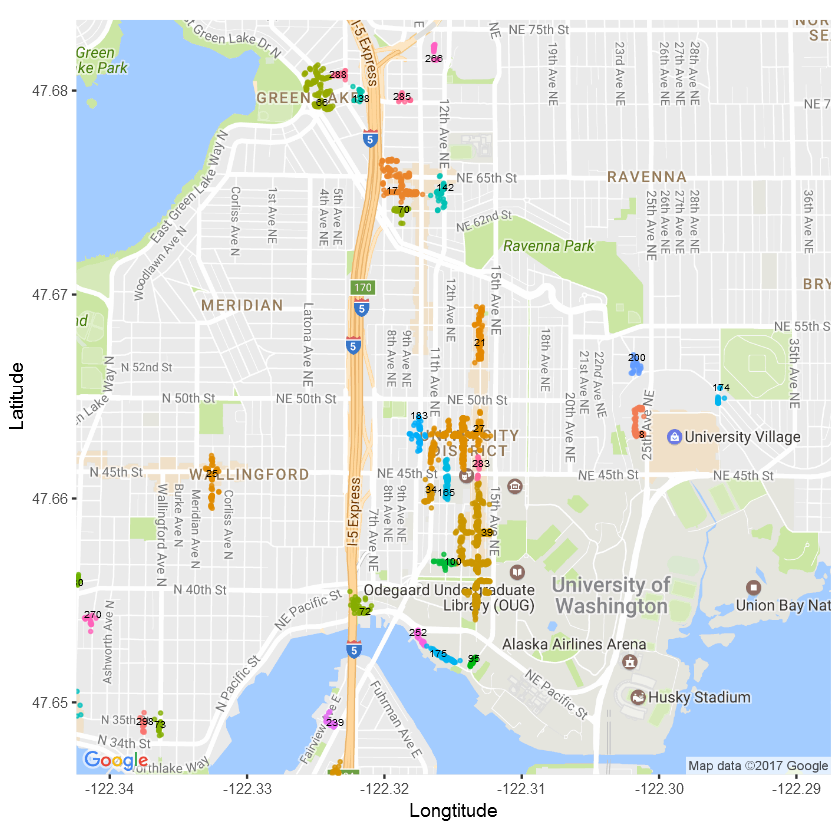

In [102]:
zoomSize=14
temp=dt2[c>0];nrow(temp)
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
centerX=-122.315
centerY=47.665
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'roadmap'))
p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(c)),size=0.5,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],c],nudge_x = 0.00005,nudge_y = 0.00005,aes(x=lon,y=lat,label=c),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position="none")
p

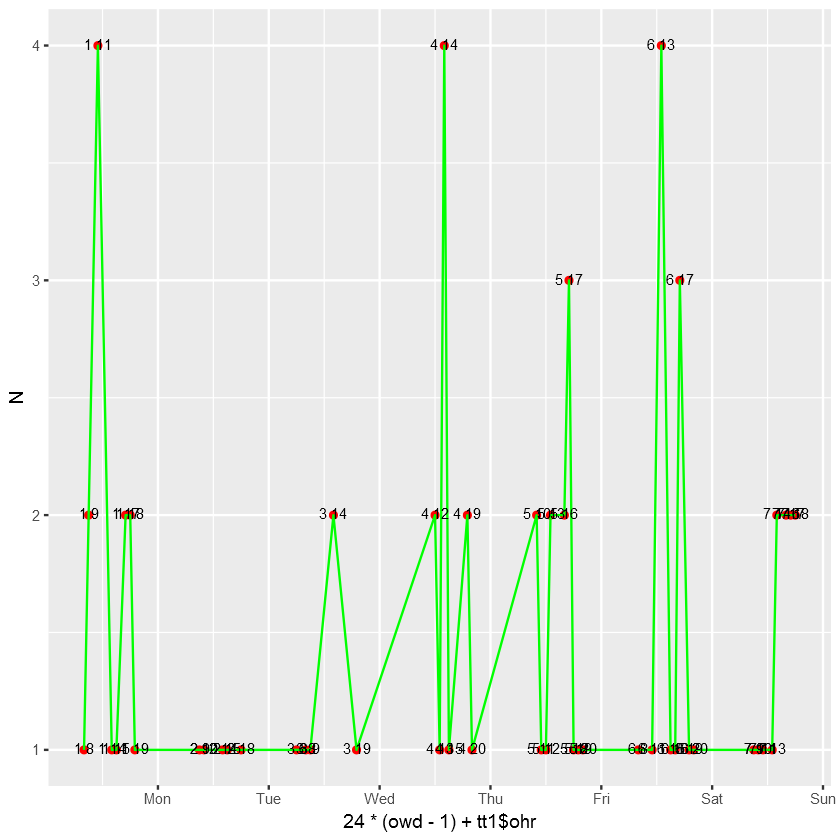

In [92]:
tt1=temp[c==8,.N,list(owd,ohr)];setkey(tt1,owd,ohr)
p=ggplot()
p=p+geom_point(data=tt1,aes(x=24*(owd-1)+tt1$ohr,y=N),col='red')
p=p+geom_path(data=tt1,aes(x=24*(owd-1)+tt1$ohr,y=N),col='green')
p=p+geom_text(data=tt1,nudge_x = 0.005,nudge_y = 0.005,aes(x=24*(owd-1)+tt1$ohr,y=N,label=paste(owd,ohr)),color='black',size=3)
p=p+scale_x_continuous(breaks =seq(0,7*24,24),labels=c('Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun'))
p

[1] 292

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=47.675065,-122.317915&zoom=17&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


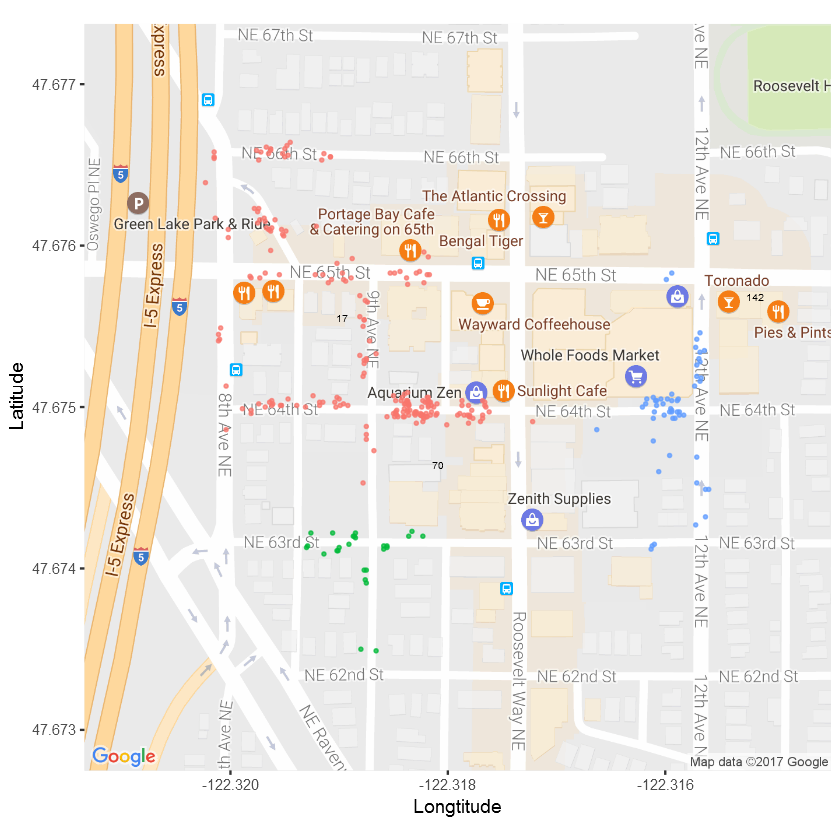

In [319]:
zoomSize=17
temp=dt2[c>0&c%in%c(17,70,142)];nrow(temp)
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))

p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'roadmap'))
p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(c)),size=0.5,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],c],nudge_x = 0.0005,nudge_y = 0.0005,aes(x=lon,y=lat,label=c),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position="none")
p

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=47.620295,-122.352795&zoom=11&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


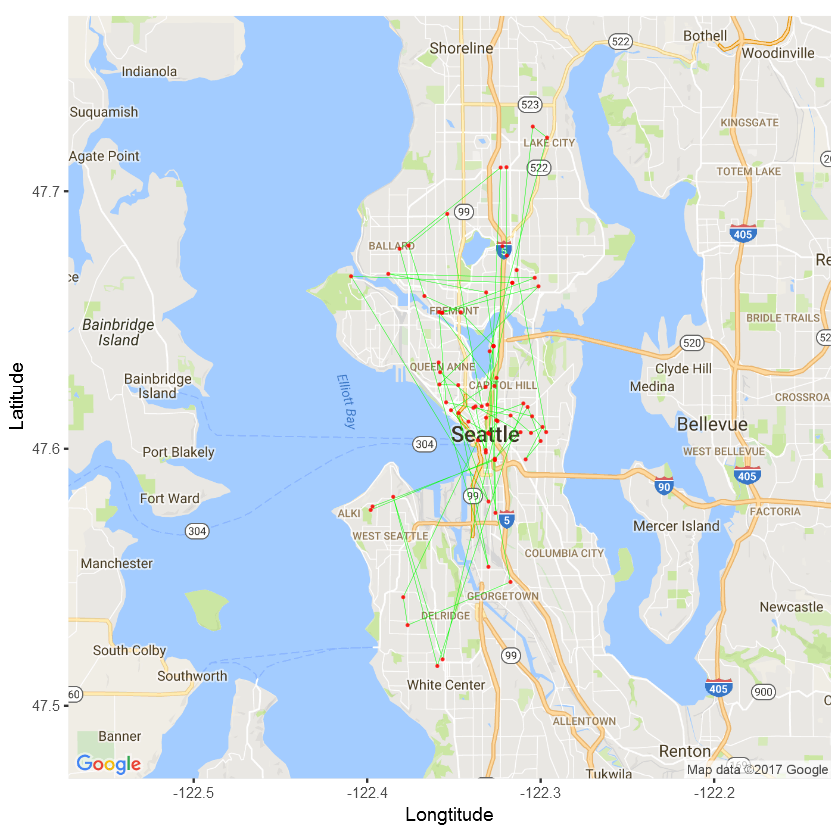

In [308]:
zoomSize=11
ids=unique(dt$id)
temp=dt[id==ids[1],list(id,omd,ohr,omi,duration,lon=olon,lat=olat)]
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
#centerX=-122.3
#centerY=47.6
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'roadmap'))
p=p+geom_path(data=temp,aes(x=lon,y=lat),color='green',size=0.1)
p=p+geom_point(data=temp,aes(x=lon,y=lat),color='red',size=0.1,alpha=0.75)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.9,0.2))
p

In [ ]:
#anormal event detection, collection event
#POI detection
#demand detection
#explore popular place base on one-way free foalting carsharing systems
#inflow and outflow of each grids
#parking places and interesting places

In [129]:
angle<-function(x1,y1,x2,y2){
    angle = atan2(y1,x1) - atan2(y2, x2);
    if (angle < 0) angle =angle+ 2 * pi;
    return(angle)   
}
angle(0,1,-1,-1)

[1] 3.926991